### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
# import lightgbm as lgb

### Datasets using Pandas

In [ ]:
# url = "https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/gwbz3fsgp8-2.zip"
# wget.download(url, 'D:\...\Datasets')

# wget <https://www.kaggle.com/anthonypino/melbourne-housing-market/download/archive.zip>

In [2]:
# save filepath to variable for easier access
melbourne_file_path = 'D:\...\Datasets\melb_data.csv'
# read the data and store data in DataFrame titled melbourne_data
melbourne_data = pd.read_csv(melbourne_file_path) 
# print a summary and the head of the data in Melbourne data 
# print(melbourne_data.describe())
# print(melbourne_data.head())
# print(melbourne_data.columns)
# print(melbourne_data.items)


In [3]:
# Filter rows with missing values
melbourne_data = melbourne_data.dropna(axis=0)

# Labels
y = melbourne_data.Price
# Costumized features as inputs
melbourne_features1 = ['Rooms', 'Bathroom', 'Landsize', 'Lattitude', 'Longtitude']
# All the features as inputs
melbourne_features2 = melbourne_data.drop(columns=['Price'])
X1 = melbourne_data[melbourne_features1]
# X1_index_colom = melbourne_features1
X2 = melbourne_features2

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X1, y)
train_X2, val_X2, train_y, val_y = train_test_split(X2, y)
# len(val_y)/len(y), len(val_X)/len(X1) 

### Decision Tree Model

In [4]:
# # 1st method:
# # Specify Model
# model = DecisionTreeRegressor()
# # Fit Model
# model.fit(train_X, train_y)
# # Make validation predictions and calculate mean absolute error
# preds_val = model.predict(val_X)
# mae = mean_absolute_error(val_predictions, val_y)
# print("Validation MAE: {:,.0f}".format(val_mae))

# 2nd method:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return mae

In [5]:
# Compare different leaf sizes
candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
best = []
for candidate in candidate_max_leaf_nodes:
    meanae = get_mae(candidate, train_X, val_X, train_y, val_y)
    best.append(meanae)  
# Store the best value of max_leaf_nodes (it will be either 5, 25, 50, 100, 250 or 500)
best_tree_size = (candidate_max_leaf_nodes[best.index(min(best))])
# best_tree_size, min(best)

# fitting the model with the best_leaf_size:
model = DecisionTreeRegressor(max_leaf_nodes=best_tree_size)
model.fit(train_X, train_y)
preds_val = model.predict(val_X)

### Random Forest Model

In [6]:
# Read the data from the home-data-for-ml-course 
X_full = pd.read_csv(r'D:\...\Datasets\home-data-for-ml-course\train.csv', index_col='Id')
X_test_full = pd.read_csv(r'D:\...\Datasets\home-data-for-ml-course\test.csv', index_col='Id')
# Using only numerical predictors
X_num = X_full.select_dtypes(exclude=['object'])
X_test_num = X_test_full.select_dtypes(exclude=['object'])
# Obtain target and predictors
y = X_full.SalePrice
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = X_full[features].copy()
X_test = X_test_full[features].copy()

# Break off training-validation set from numerical training data
X_train, X_valid, y_train, y_valid = train_test_split(X_num, y, train_size=0.8)
# Break off training-validation set from featured training data
X_train_features, X_valid_features, y_train, y_valid = train_test_split(X, y, train_size=0.8)
# Break off training-validation set from full training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, train_size=0.8)

#### Missing values

In [7]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)
# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]

# 1st method :
# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1) #,inplace=True)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1) #,inplace=True)

# 2nd method
# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))  # Fit to data, then transform it.
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))  # Only impute all missing values in X, without fitting.
# Imputation removed column names; so put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

# 3rd method
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()
# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()
# Imputation 
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))
# Imputation removed column names; so put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

(1168, 37)
LotFrontage    210
MasVnrArea       8
GarageYrBlt     64
dtype: int64


In [8]:
# function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [9]:
# 1st: Define the model with reduced data
print("MAE from Approach 1: reduced data")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))
# 2nd: Define the model with imputed data
print("MAE from Approach 2: imputed data")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE from Approach 1: reduced data
62174.93595890411
MAE from Approach 2: imputed data
62255.95434931506


In [10]:
# Define different Random Forest models
model_1 = RandomForestRegressor(n_estimators=50)
model_2 = RandomForestRegressor(n_estimators=100)
model_3 = RandomForestRegressor(n_estimators=100, criterion='mae')
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7)

models = [model_1, model_2, model_3, model_4, model_5]

# Function for comparing different models
def score_model(model, X_t=X_train_features, X_v=X_valid_features, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    mae = score_model(models[i])
    print("Model %d MAE: %d" % (i+1, mae))
    
mae = []
for i in range(0, len(models)):
    mae.append(score_model(models[i]))
for i in range(0, len(models)):
    if mae[i] == min(mae):
        best_model = models[i]

my_model = best_model
# fitting the best model
my_model.fit(X_train_features,y_train)
my_preds_test = my_model.predict(X_test)

Model 1 MAE: 65290
Model 2 MAE: 65355
Model 3 MAE: 65130
Model 4 MAE: 62579
Model 5 MAE: 61623


#### Data colomns with cathegorical and numerical values

In [17]:
# Separate target from predictors
y = melbourne_data.Price
X = melbourne_data.drop(['Price'], axis=1)
# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# "Cardinality" means the number of unique values in a column
# Selecting categorical columns with relatively low cardinality (= 1 to 15) (convenient but arbitrary) 
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]
# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]
# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

# Get list of categorical variables
print(low_cardinality_cols)
# s = (X_train.dtypes == 'object')
# object_cols = list(s[s].index)
# print("Categorical variables:")
# print(object_cols)

# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X_train[col].nunique(), low_cardinality_cols))
d = dict(zip(low_cardinality_cols, object_nunique))
# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1]) 

['Type', 'Method', 'Regionname']


C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[('Type', 3), ('Method', 5), ('Regionname', 8)]

In [18]:
# 1st method: Drop Categorical Variables
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

# 2nd method: Ordinal Encoding
# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()
# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[low_cardinality_cols] = ordinal_encoder.fit_transform(X_train[low_cardinality_cols])
label_X_valid[low_cardinality_cols] = ordinal_encoder.transform(X_valid[low_cardinality_cols])

# 3rd method: OneHotEncoder
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_cols]))
# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index
# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(low_cardinality_cols, axis=1)
num_X_valid = X_valid.drop(low_cardinality_cols, axis=1)
# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)


In [19]:
# 1st: Define the model
print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))
# 2nd: Define the model with Ordinal encoded data
print("MAE from Approach 2 (Ordinal encoder for categorical variables):")
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))
# 3rd: Define the model with OH encoded data
print("MAE from Approach 3 (One Hot Encoder for categorical variables):")
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
182482.47458256525
MAE from Approach 2 (Ordinal encoder for categorical variables):
180631.3939907834
MAE from Approach 3 (One Hot Encoder for categorical variables):
177878.71885483872


In [20]:
# # Save predictions in format used for competition scoring
# output = pd.DataFrame({'Id': X_test.index, 'SalePrice': preds_test})
# output.to_csv('submission.csv', index=False) 

### Pipelines

In [21]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, low_cardinality_cols)
    ])

model = RandomForestRegressor(n_estimators=100, random_state=0)
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)
# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

# # Preprocessing of test data, fit model
# preds_test = my_pipeline.predict(X_test) 

MAE: 178112.1407822581


### Cross Validation

In [22]:
# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print("Average MAE score (across experiments):")
print(scores.mean())

MAE scores:
 [222597.73887903 202468.83454168 182654.21047619 161393.31001883
 158724.26229755]
Average MAE score (across experiments):
185567.67124265764


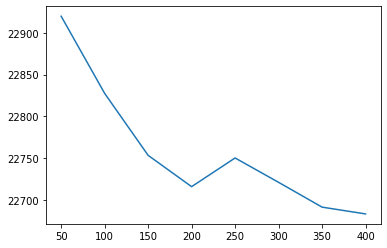

In [27]:
y = X_full.SalePrice
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = X_full[features].copy()

def get_score(n_estimators):
    my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=n_estimators,random_state=0))
                             ])
    scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=10,
                              scoring='neg_mean_absolute_error')
    m = scores.mean()
    return m

n_estimators = [50, 100, 150, 200, 250, 300, 350, 400]
results = {}
for i in range(0,len(n_estimators)):
    results[n_estimators[i]] = get_score(n_estimators[i]) 

plt.plot(list(results.keys()), list(results.values()))
plt.show()

### XGBoost (eXtreme Gradient Boosting) : a level_wise growth appraoch

In [28]:
# Read the data from the home-data-for-ml-course 
X_full = pd.read_csv(r'D:\projets\AI_py_tutorials\Datasets\home-data-for-ml-course\train.csv', index_col='Id')
X_test_full = pd.read_csv(r'D:\projets\AI_py_tutorials\Datasets\home-data-for-ml-course\test.csv', index_col='Id')
# Obtain target and predictors
y = X_full.SalePrice
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = X_full[features].copy()
X_test = X_test_full[features].copy()
# Break off training-validation set from featured training data
X_train_features, X_valid_features, y_train, y_valid = train_test_split(X, y, train_size=0.8)


my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05) # , n_jobs=4) number of cores!
my_model.fit(X_train_features, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid_features, y_valid)], 
             verbose=False)

# Get predictions
predictions = my_model.predict(X_valid_features)
# Calculate MAE
mae = mean_absolute_error(y_valid, predictions)
print("Average MAE score: {}".format(mae))
test_predictions = my_model.predict(X_test)
test_predictions 

Average MAE score: 22019.079663420376


array([119441.37, 164351.1 , 187794.45, ..., 153774.11, 143085.06,
       235366.62], dtype=float32)

### leakage

#### Target leakage
Target leakage occurs when your predictors include data that will not be available at the time you make predictions.
#### Train-Test Contamination
A different type of leak occurs when you aren't careful to distinguish training data from validation data.

### LGBM (Light Gradient Boost Machine) : a leaf_wise growth appraoch

In [29]:
X = pd.read_csv(r'D:\projets\AI_py_tutorials\Datasets\tabular-playground-series-feb-2021\train.csv',encoding='utf-8',index_col=0)
test = pd.read_csv(r'D:\projets\AI_py_tutorials\Datasets\tabular-playground-series-feb-2021\test.csv',encoding='utf-8',index_col=0)

y = X['target']
X = X.drop(['target'], axis= 1)

label = LabelEncoder()
categorical_feature = np.where(X.dtypes != 'float64')[0].tolist()
categorical_feature_columns = X.select_dtypes(exclude=['float64']).columns

for column in categorical_feature_columns:
        label.fit(X[column])
        X[column] = label.transform(X[column])
        test[column] = label.transform(test[column])

In [30]:
lgbm_parameters = {
    'metric': 'rmse', 
    'n_jobs': -1,
    'n_estimators': 50000,
    'reg_alpha': 10.924491968127692,
    'reg_lambda': 17.396730654687218,
    'colsample_bytree': 0.21497646795452627,
    'subsample': 0.7582562557431147,
    'learning_rate': 0.009985133666265425,
    'max_depth': 18,
    'num_leaves': 63,    # num_leaves=2^(max_depth)
    'min_child_samples': 27,
    'max_bin': 523,
    'cat_l2': 0.025083670064082797
}

In [ ]:
# import optuna
# def objective(trial):
#     X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
#     dtrain = lgb.Dataset(X_train, label=y_train)

#     param = {
#         "objective": "binary",
#         "metric": "binary_logloss",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#     }

#     gbm = lgb.train(param, dtrain)
#     preds = gbm.predict(X_test)
#     pred_labels = np.rint(preds)
#     accuracy = sklearn.metrics.accuracy_score(y_test, pred_labels)
#     return accuracy
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)